In [1]:
import pandas as pd 
import numpy as np
import csv
import advanced_functions as advance
import stumps
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_curve, auc

### EBM

In [2]:
### train data
train_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_train.csv")
train_data = train_data.drop(['person_id', 'screening_date'], axis=1)
train_X = train_data.loc[:,:'five_year']
train_Y = train_data['recid_two_year'].values

### test data
test_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_test.csv")
test_data = test_data.drop(['person_id', 'screening_date'], axis=1)
test_X = test_data.loc[:,:'five_year']
test_Y = test_data['recid_two_year'].values

In [3]:
#### GAM
estimators = [40]
depth = [1]
learning_rate = [0.03]
holdout_split = [0.9]
ebm_summary = advance.EBM(train_X, train_Y, test_X, test_Y, learning_rate,depth,estimators,holdout_split,816)

C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### Lasso Stumps

In [2]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_stumps.csv")
#data = data.drop(['person_id', 'screening_date'], axis=1)
X_stumps, Y_stumps = data.loc[:,:'five_year>=1'], data['recid_two_year'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns

In [3]:
cols

Index(['sex>=1', 'p_current_age>=18', 'p_current_age>=19', 'p_current_age>=23',
       'p_current_age>=27', 'p_current_age>=29', 'p_current_age>=30',
       'p_current_age>=31', 'p_current_age>=33', 'p_current_age>=37',
       ...
       'years_since_last_crime>=2.5', 'years_since_last_crime>=3',
       'years_since_last_crime>=3.5', 'years_since_last_crime>=4',
       'years_since_last_crime>=4.5', 'years_since_last_crime>=5',
       'six_month>=1', 'one_year>=1', 'three_year>=1', 'five_year>=1'],
      dtype='object', length=158)

In [6]:
### stumps model
alpha = [0.001]
Stump = stumps.stump_features(X_stumps, Y_stumps, cols, alpha, 816)

In [7]:
np.mean(Stump['test_auc']), np.mean(Stump['train_auc']), Stump['auc_diff']

(0.7325514386373156, 0.7316503073675398, 0.09020009542514529)

In [18]:
stumps.stump_table(Stump['coefs'], Stump['features'], Stump['intercept'], Stump['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| p_current_age>=30                 | -0.068         |
| p_age_first_offense<=20           | 0.018          |
| p_age_first_offense<=23           | 0.016          |
| p_charge>=11                      | 0.017          |
| prior_conviction_M>=4             | 0.035          |
| prior_conviction_M>=5             | 0.047          |
| p_arrest>=6                       | 0.008          |
| years_since_last_crime>=1         | -0.038         |
| years_since_last_crime>=1.5       | -0.001         |
| years_since_last_crime>=3         | -0.029         |
| three_year>=1                     | 0.0            |
| Intercept                         | 0.461          |
|====================================================|
| ADD POINTS FROM ROWS 1 TO 11      | Total Score    |
+-----------------------------------+----------------+


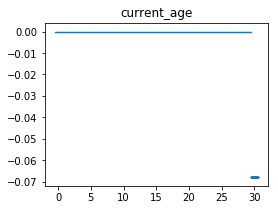

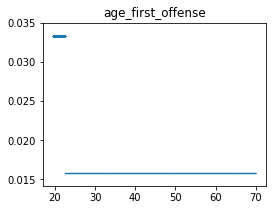

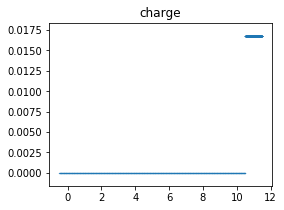

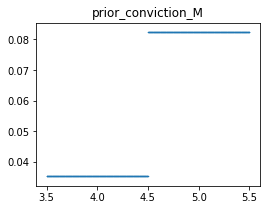

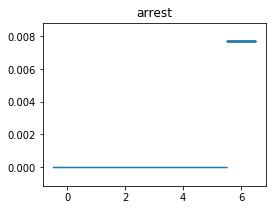

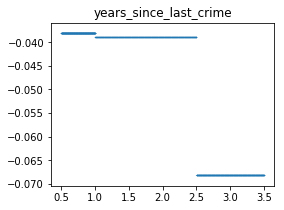

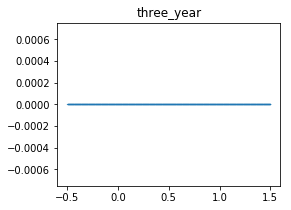

In [19]:
stumps.stump_plots(Stump['features'], Stump['coefs'])

### Arnold PSA

In [21]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_arnold.csv")
X_arnold_raw = data['arnold_nca_raw'].values
X_arnold_calc = data['arnold_nca'].values
Y_arnold = data['recid_two_year'].values

In [22]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []
calc_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_pred_calc, y_test = X_arnold_raw[test], X_arnold_calc[test], Y_arnold[test]
    raw_fpr, raw_tpr, raw_thresholds = roc_curve(y_test, y_pred_raw)
    calc_fpr, calc_tpr, calc_thresholds = roc_curve(y_test, y_pred_calc)
    raw_auc.append(auc(raw_fpr, raw_tpr))
    calc_auc.append(auc(calc_fpr, calc_tpr))
    i+=1 

### Results

In [23]:
results = [["EBM", ebm_summary['best_validation_auc'], ebm_summary['best_validation_std'], ebm_summary['best_param']], 
           ['Lasso Stumps', round(np.mean(Stump['test_auc']),3), round(np.std(Stump['test_auc']),3)], 
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3), round(np.std(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3), round(np.std(calc_auc), 3)]]

In [24]:
results

[['AdaBoost',
  0.6438730033461224,
  0.018642382119523626,
  {'learning_rate': 0.05, 'n_estimators': 10}],
 ['EBM',
  0.6596007200011168,
  0.02375994427912098,
  {'holdout_split': 0.9,
   'learning_rate': 0.03,
   'max_tree_splits': 1,
   'n_estimators': 40}],
 ['Lasso Stumps', 0.674, 0.007],
 ['Arnold PSA Raw', 0.611, 0.045],
 ['Arnold PSA', 0.605, 0.043]]

In [28]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model results/Advanced Models/Two Year/"
results = [["", "EBM", "std", "Lasso Stumps", "std", "Arnold PSA Raw", "std", "Arnold PSA", "std"],
           ["General", round(ebm_summary['best_validation_auc'],3), round(ebm_summary['best_validation_std'], 3), round(np.mean(Stump['test_auc']),3), round(np.std(Stump['test_auc']),3), round(np.mean(raw_auc), 3), round(np.std(raw_auc), 3), round(np.mean(calc_auc), 3), round(np.std(calc_auc), 3)]]
with open(path + 'Advanced Models Summary.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)